In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image

In [23]:
train_dir = 'workspace/images/train'
validation_dir = 'workspace/images/val'
test_dir = 'workspace/images/test'

IMG_SIZE = (299, 299)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    image_size=IMG_SIZE)

Found 560 files belonging to 2 classes.
Found 70 files belonging to 2 classes.
Found 70 files belonging to 2 classes.


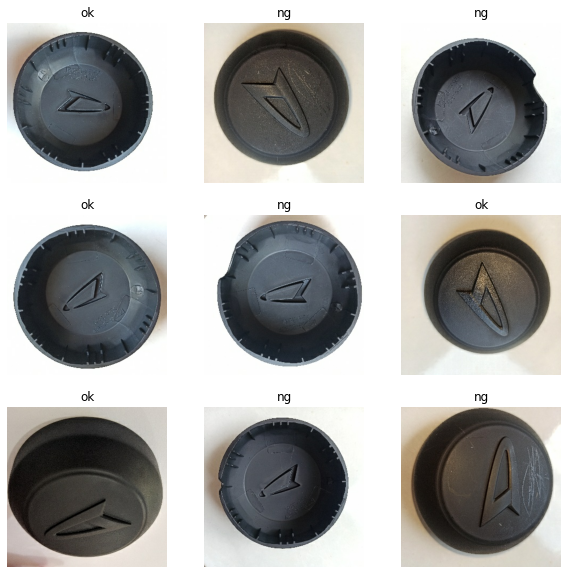

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomTranslation(0.08, 0.08, fill_mode='nearest'),
  tf.keras.layers.RandomRotation(0.5),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 9s 1s/step - loss: 0.7582 - accuracy: 0.3714


In [9]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.37


In [10]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
18/18 [==============================] - 11s 431ms/step - loss: 0.7585 - accuracy: 0.4518 - val_loss: 0.7256 - val_accuracy: 0.5429
Epoch 2/10
18/18 [==============================] - 5s 285ms/step - loss: 0.7457 - accuracy: 0.4839 - val_loss: 0.7123 - val_accuracy: 0.5714
Epoch 3/10
18/18 [==============================] - 5s 283ms/step - loss: 0.7278 - accuracy: 0.4821 - val_loss: 0.6973 - val_accuracy: 0.5857
Epoch 4/10
18/18 [==============================] - 5s 284ms/step - loss: 0.7054 - accuracy: 0.5161 - val_loss: 0.6830 - val_accuracy: 0.6143
Epoch 5/10
18/18 [==============================] - 5s 284ms/step - loss: 0.6894 - accuracy: 0.5339 - val_loss: 0.6693 - val_accuracy: 0.6143
Epoch 6/10
18/18 [==============================] - 5s 285ms/step - loss: 0.6786 - accuracy: 0.5750 - val_loss: 0.6549 - val_accuracy: 0.6143
Epoch 7/10
18/18 [==============================] - 5s 285ms/step - loss: 0.6558 - accuracy: 0.5714 - val_loss: 0.6442 - val_accuracy: 0.6286
Epoch

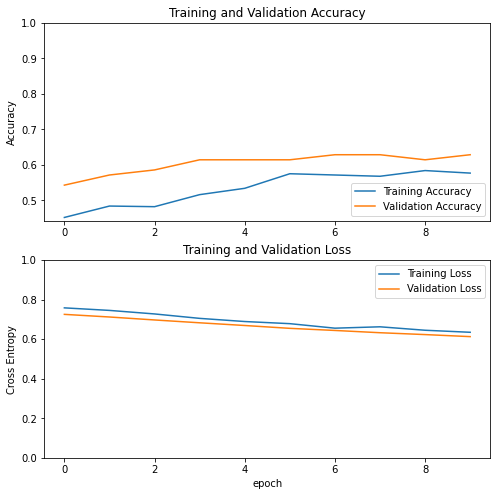

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
base_model.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [16]:
len(model.trainable_variables)

98

In [17]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/30
18/18 [==============================] - 19s 674ms/step - loss: 0.5134 - accuracy: 0.7268 - val_loss: 0.3928 - val_accuracy: 0.7571
Epoch 11/30
18/18 [==============================] - 10s 554ms/step - loss: 0.2965 - accuracy: 0.8661 - val_loss: 0.2556 - val_accuracy: 0.8714
Epoch 12/30
18/18 [==============================] - 10s 554ms/step - loss: 0.2095 - accuracy: 0.9232 - val_loss: 0.2840 - val_accuracy: 0.9143
Epoch 13/30
18/18 [==============================] - 10s 557ms/step - loss: 0.1604 - accuracy: 0.9429 - val_loss: 0.1420 - val_accuracy: 0.9714
Epoch 14/30
18/18 [==============================] - 10s 560ms/step - loss: 0.1288 - accuracy: 0.9464 - val_loss: 0.1155 - val_accuracy: 0.9857
Epoch 15/30
18/18 [==============================] - 10s 558ms/step - loss: 0.0811 - accuracy: 0.9750 - val_loss: 0.0734 - val_accuracy: 0.9857
Epoch 16/30
18/18 [==============================] - 10s 559ms/step - loss: 0.0696 - accuracy: 0.9804 - val_loss: 0.2192 - val_accuracy:

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

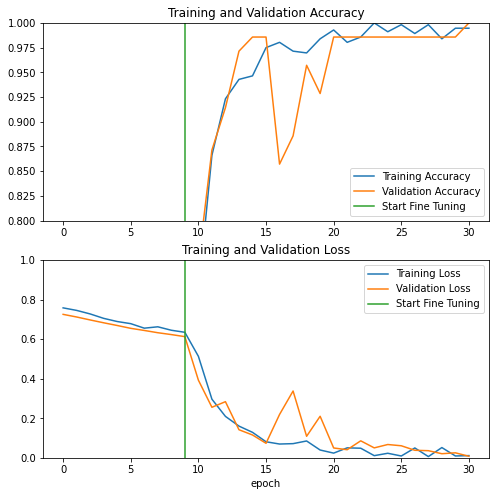

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 1s 156ms/step - loss: 0.0061 - accuracy: 1.0000
Test accuracy : 1.0


In [21]:
model.save('dai-v3.h5')

Predictions Batch:
 [1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1]
Labels Batch:
 [1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1]
Prediction for an image: [1], the image is ok


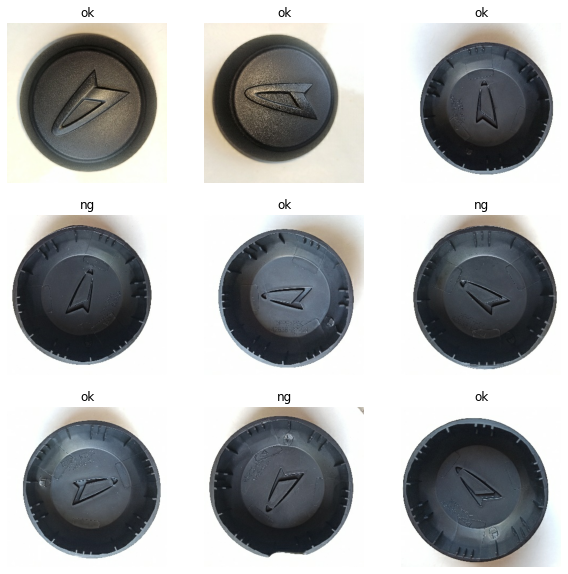

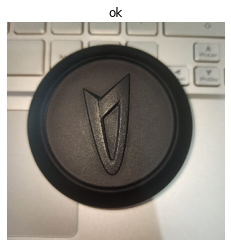

In [31]:
loaded_model = tf.keras.models.load_model('dai-v3.h5')

img = image.load_img('testingok2.jpeg', target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = loaded_model.predict_on_batch(image_batch).flatten()
pred = loaded_model.predict(images)
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
pred1 = tf.nn.sigmoid(pred[0])
pred2 = tf.where(pred1 < 0.5, 0, 1)

if pred2 == 0:
  label = 'ng'
else:
  label = 'ok'

print('Predictions Batch:\n', predictions.numpy())
print('Labels Batch:\n', label_batch)

print(f'Prediction for an image: {pred2.numpy()}, the image is {label}')

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(train_dataset.class_names[predictions[i]])
  plt.axis('off')

plt.figure()
plt.axis('off')
plt.title(label)
result = plt.imshow(img)